# **Monte-Carlo Simulations to compute VaR and Expected Shortfall**

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Settings the figsize parameter for the plots in this notebook to standardize the size of plots
plt.rcParams["figure.figsize"] = (10, 5)

In [11]:
stock_data=yf.download("NVDA", start="2010-01-01", end=dt.datetime.now().strftime("%Y-%m-%d"))
stock_data = stock_data.droplevel(1, axis=1)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,0.423807,0.426786,0.415097,0.424265,800204000
2010-01-05,0.429995,0.434580,0.422202,0.422202,728648000
2010-01-06,0.432746,0.433663,0.425640,0.429766,649168000
2010-01-07,0.424265,0.432287,0.421056,0.430454,547792000
2010-01-08,0.425182,0.428162,0.418306,0.420827,478168000


In [ ]:
stock_data["Simple_returns"]=(stock_data["Close"]/stock_data["Close"].shift(1))-1
#Alternative way to calculate returns
# stock_data["pct_change"]=stock_data["Close"].pct_change() 
stock_data.tail(5)


Price,Close,High,Low,Open,Volume,Simple_returns
Date,,,,,,
2025-12-24,188.610001,188.910004,186.589996,187.940002,65528500,-0.003171
2025-12-26,190.529999,192.690002,188.000000,189.919998,139740300,0.010180
2025-12-29,188.220001,188.759995,185.910004,187.710007,120006100,-0.012124
2025-12-30,187.539993,188.990005,186.929993,188.240005,97687300,-0.003613
2025-12-31,186.500000,190.559998,186.490005,189.570007,119731600,-0.005545


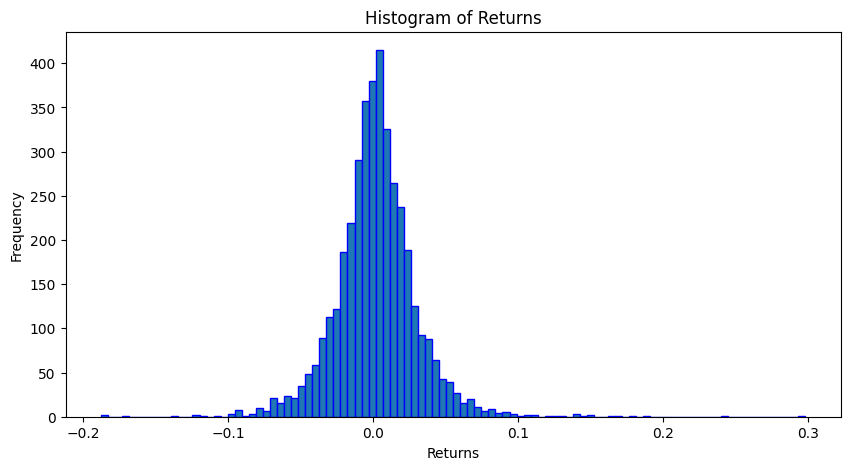

In [8]:
# Plotting the histogram of returns
plt.hist(stock_data["Simple_returns"].dropna(), bins=100, edgecolor='blue')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title("Histogram of Returns")
plt.show()



$\text{Average Annualized Return} = ( ( 1 + \mu ) ^ {252}) - 1$


Standard deviation for T time periods can be computed using the following formula:

$\sigma_{annual} = \sigma_{daily} * \sqrt{T}$

1. Compute the average daily returns and the annualized returns.
2. Compute the standard deviation of the returns and the annualized volatility.
3. Compute the annualized variance.
4. Compute the skewness and kurtosis of the returns.


In [5]:

avg_return=np.mean(stock_data["Simple_returns"])
std_dev_return= np.std(stock_data["Simple_returns"])
annualized_std_dev= std_dev_return * np.sqrt(252)
annualized_variance= annualized_std_dev **2
print("The standard deviation of return is: ", std_dev_return)
print("The daily average return is: ", avg_return)
print("The annualized standard deviation is: ", annualized_std_dev)
print("The annualized variance is: ", annualized_variance)  


The standard deviation of return is:  0.028786249251544105
The daily average return is:  0.001924915025650014
The annualized standard deviation is:  0.45696754018742947
The annualized variance is:  0.20881933278494996


In [6]:
import scipy.stats as stats
skewness=stats.skew(stock_data["Simple_returns"].dropna())
kurtosis=stats.kurtosis(stock_data["Simple_returns"].dropna(), fisher=True)
print("The skewness of returns is: ", skewness)
print("The kurtosis of returns is: ", kurtosis)

The skewness of returns is:  0.5650560003585113
The kurtosis of returns is:  8.127505047178975


In [7]:
# Import the shapiro function from the scipy.stats library
from scipy.stats import shapiro

# Compute the p_value by running the shapiro function on the returns column
t_stat, p_value = shapiro(stock_data["Simple_returns"].dropna())
print(t_stat,p_value)
# Print the results
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

0.9328618618049644 3.048035965263807e-39
Null hypothesis of normality is rejected.


The historical VaR at 95% confidence level is: -0.04197592788222126
The historical Conditional VaR at 95% confidence level is: -0.06184165069021752
[-0.18755859 -0.18452092 -0.16968162 ...  0.18722739  0.24369637
  0.29806716]
[2.48570718e-04 4.97141437e-04 7.45712155e-04 ... 9.99502859e-01
 9.99751429e-01 1.00000000e+00]


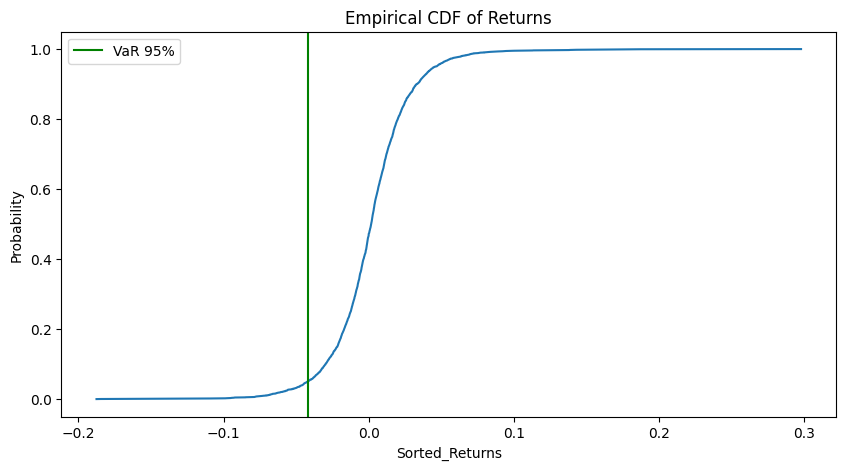

-0.04197592788222126


In [9]:
# Define the var level parameter
var_level = 95
significance_level = 1 - (var_level / 100)
# Compute and print the historical VaR
historical_var = np.percentile(stock_data["Simple_returns"].dropna(), significance_level * 100)
print(f"The historical VaR at {var_level}% confidence level is: {historical_var}")
historical_conditional_var = stock_data["Simple_returns"].dropna()[stock_data["Simple_returns"].dropna() <= historical_var].mean()
print(f"The historical Conditional VaR at {var_level}% confidence level is: {historical_conditional_var}")

# Sort the returns for plotting
sorted_returns = np.sort(stock_data["Simple_returns"].dropna())
probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

print(sorted_returns)
print(probabilities)
# Plot the probability of each sorted return quantile
plt.plot(sorted_returns, probabilities)
plt.xlabel("Sorted_Returns")
plt.ylabel("Probability")
plt.title("Empirical CDF of Returns")

# Draw a vertical line in the plot for the VaR 95 quantile
plt.axvline(x=historical_var, color='g', linestyle='-', label=f'VaR {var_level}%')
plt.legend()
plt.show()
print(historical_var)


The Expected Shortfall at 95% confidence level is: -0.06184165069021752


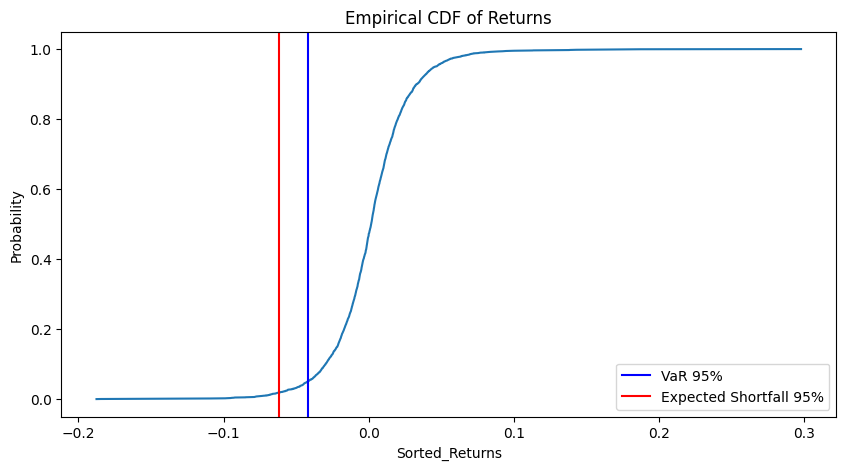

In [10]:
# Compute and print the expected shortfall
Expected_Shortfall = stock_data["Simple_returns"].dropna()[stock_data["Simple_returns"].dropna() <= historical_var].mean()
print(f"The Expected Shortfall at {var_level}% confidence level is: {Expected_Shortfall}")

# Sort the returns for plotting
sorted_returns = np.sort(stock_data["Simple_returns"].dropna())
probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

# Plot the probability of each sorted return quantile   
plt.plot(sorted_returns, probabilities)
plt.xlabel("Sorted_Returns")
plt.ylabel("Probability")
plt.title("Empirical CDF of Returns")   

# Draw vertical lines in the plot for the VaR 95 and CVaR quantiles
plt.axvline(x=historical_var, color='b', linestyle='-', label=f'VaR {var_level}%')
plt.axvline(x=Expected_Shortfall, color='r', linestyle='-', label=f'Expected Shortfall {var_level}%')
plt.legend()
plt.show()